In [2]:
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn
import torch
import torch.nn.functional as FF
from pytorch_forecasting import TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping
import lightning.pytorch as pl

/Users/sunzh81/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 1. Data Preparation

In [3]:
import numpy as np
import pandas as pd


length = 3000

series = pd.DataFrame({
    "ds": pd.date_range("2021-01-01", periods=length, freq="D"),
    "y": np.sin(np.linspace(0, 100, length)) + 0.2 * np.random.randn(length)
})

# Inject anomalies
anomaly_indices = [250, 500, 700, 850]
anomaly_magnitudes = [5, -6, 8, -7]
series["is_anomaly"] = 0
for idx, mag in zip(anomaly_indices, anomaly_magnitudes):
    series.loc[idx, "y"] += mag
    series.loc[idx, "is_anomaly"] = 1

series["unique_id"] = "SYN"
series = series.reset_index().rename(columns={"ds": "ds"})

# Make sure 'ds' is datetime
series["ds"] = pd.to_datetime(series["ds"])


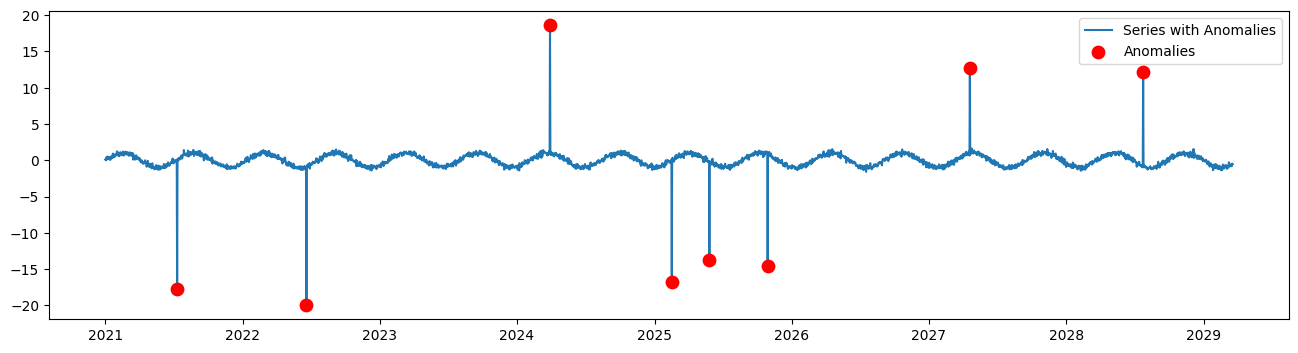

In [4]:
import numpy as np
import pandas as pd

def inject_anomalies(series, n_anomalies=8, magnitude_range=(5, 10), seed=None):
    """
    Injects anomalies into a time series DataFrame.
    Adds an 'is_anomaly' column (1 if anomaly, 0 otherwise).
    Randomly selects n_anomalies locations and modifies 'y' with a spike/drop.
    """
    if seed is not None:
        np.random.seed(seed)
    length = len(series)
    # Avoid the very start/end
    anomaly_indices = np.random.choice(np.arange(50, length-50), size=n_anomalies, replace=False)
    anomaly_magnitudes = np.random.uniform(*magnitude_range, size=n_anomalies)
    # Randomly choose if each is spike or drop
    anomaly_magnitudes *= np.random.choice([-1, 1], size=n_anomalies)
    series = series.copy()
    series["is_anomaly"] = 0
    for idx, mag in zip(anomaly_indices, anomaly_magnitudes):
        series.loc[idx, "y"] += mag
        series.loc[idx, "is_anomaly"] = 1
    return series, anomaly_indices, anomaly_magnitudes


N_LAGS = 96

np.random.seed(42)
length = 3000
series = pd.DataFrame({
    "ds": pd.date_range("2021-01-01", periods=length, freq="D"),
    "y": np.sin(np.linspace(0, 100, length)) + 0.2 * np.random.randn(length)
})

series, anomaly_indices, anomaly_magnitudes = inject_anomalies(series, n_anomalies=8, magnitude_range=(5, 10), seed=42)
series["is_anomaly"] = 0
for idx, mag in zip(anomaly_indices, anomaly_magnitudes):
    series.loc[idx, "y"] += mag
    series.loc[idx, "is_anomaly"] = 1

series["unique_id"] = "SYN"
series = series.reset_index().rename(columns={"ds": "ds"})

# Make sure 'ds' is datetime
series["ds"] = pd.to_datetime(series["ds"])

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.plot(series["ds"], series["y"], label="Series with Anomalies")
plt.scatter(series.loc[anomaly_indices, "ds"], series.loc[anomaly_indices, "y"], 
            color="red", label="Anomalies", zorder=5, s=80)
plt.legend()
plt.show()


In [5]:
series

,index,ds,y,is_anomaly,unique_id
0,0,2021-01-01,0.099343,0,SYN
1,1,2021-01-02,0.005685,0,SYN
2,2,2021-01-03,0.196177,0,SYN
3,3,2021-01-04,0.404473,0,SYN
4,4,2021-01-05,0.086152,0,SYN
...,...,...,...,...,...
2995,2995,2029-03-15,-0.601046,0,SYN
2996,2996,2029-03-16,-0.538401,0,SYN
2997,2997,2029-03-17,-0.811057,0,SYN
2998,2998,2029-03-18,-0.467997,0,SYN


In [14]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data: pd.DataFrame, n_lags: int, batch_size: int):
        super().__init__()

        self.data = data
        self.batch_size = batch_size
        self.n_lags = n_lags

        self.train_df = None
        self.test_df = None
        self.training = None
        self.validation = None
        self.predict_set = None

    def setup(self, stage=None):
        self.data["timestep"] = np.arange(self.data.shape[0])

        unique_times = self.data["timestep"].sort_values().unique()

        tr_ind, ts_ind = train_test_split(unique_times, test_size=0.2, shuffle=False)

        tr_ind, vl_ind = train_test_split(tr_ind, test_size=0.2, shuffle=False)

        self.train_df = self.data.loc[self.data["timestep"].isin(tr_ind), :]
        #self.test_df = self.data.loc[self.data["timestep"].isin(ts_ind), :]
        self.test_df = self.data
        validation_df = self.data.loc[self.data["timestep"].isin(vl_ind), :]

        self.training = TimeSeriesDataSet(
            data=self.train_df,
            time_idx="timestep",
            target="y",
            group_ids=["unique_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=1,
            time_varying_unknown_reals=["y"],
        )

        self.validation = TimeSeriesDataSet.from_dataset(self.training, validation_df)
        self.test = TimeSeriesDataSet.from_dataset(self.training, self.test_df)
        self.predict_set = TimeSeriesDataSet.from_dataset(
            self.training, self.data, predict=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def val_dataloader(self):
        return self.validation.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return self.predict_set.to_dataloader(batch_size=1, shuffle=False)

In [15]:
datamodule = DataModule(
    data=series.drop("is_anomaly", axis=1), n_lags=N_LAGS, batch_size=16
)


# 2. LSTM Autoencoder Model

In [17]:
class Encoder(nn.Module):
    def __init__(self, context_len, n_variables, hidden_dim=144, embedding_dim=4, dropout_rate=0.2):
        super().__init__()
        self.context_len, self.n_variables = context_len, n_variables
        self.hidden_dim, self.embedding_dim = hidden_dim, embedding_dim

        self.lstm1 = nn.LSTM(input_size=self.n_variables,
                             hidden_size=self.hidden_dim,
                             num_layers=1,
                             batch_first=True)
        self.bn1 = nn.BatchNorm1d(self.context_len)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(input_size=self.hidden_dim,
                             hidden_size=self.embedding_dim,
                             num_layers=1,
                             batch_first=True)
        self.bn2 = nn.BatchNorm1d(self.context_len)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x: [batch, seq_len, n_variables]
        x, _ = self.lstm1(x)
        x = FF.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x, (hidden_n, _) = self.lstm2(x)
        x = FF.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        # Take last hidden state as code
        batch_size = x.shape[0]
        return hidden_n.reshape((batch_size, self.embedding_dim))

class Decoder(nn.Module):
    def __init__(self, context_len, n_variables=1, hidden_dim=144, embedding_dim=4, dropout_rate=0.2):
        super().__init__()
        self.context_len, self.embedding_dim, self.hidden_dim, self.n_variables = context_len, embedding_dim, hidden_dim, n_variables

        self.lstm1 = nn.LSTM(input_size=self.embedding_dim,
                             hidden_size=self.embedding_dim,
                             num_layers=1,
                             batch_first=True)
        self.bn1 = nn.BatchNorm1d(self.context_len)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(input_size=self.embedding_dim,
                             hidden_size=self.hidden_dim,
                             num_layers=1,
                             batch_first=True)
        self.bn2 = nn.BatchNorm1d(self.context_len)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(self.hidden_dim, self.n_variables)

    def forward(self, x):
        # x: [batch, embedding_dim]
        batch_size = x.shape[0]
        # Repeat the code for each step in the sequence
        x = x.unsqueeze(1).repeat(1, self.context_len, 1)  # [batch, seq_len, embedding_dim]
        x, _ = self.lstm1(x)
        x = FF.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = FF.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.output_layer(x)
        return x

class AutoencoderLSTM(pl.LightningModule):
    def __init__(self, context_len, n_variables, hidden_dim=64, embedding_dim=32, dropout_rate=0.2, learning_rate=0.001):
        super().__init__()
        self.encoder = Encoder(context_len, n_variables, hidden_dim, embedding_dim, dropout_rate)
        self.decoder = Decoder(context_len, n_variables, hidden_dim, embedding_dim, dropout_rate)
        self.learning_rate = learning_rate

    def forward(self, x):
        xh = self.encoder(x)
        xh = self.decoder(xh)
        return xh

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = FF.mse_loss(y_pred, x["encoder_cont"])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = FF.mse_loss(y_pred, x["encoder_cont"])
        self.log("val_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = FF.mse_loss(y_pred, x["encoder_cont"])
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


# 3. Training Loop

How to interpret train/val loss, what does magnitude mean?


In [18]:
model = AutoencoderLSTM(n_variables=1, context_len=N_LAGS, embedding_dim=2)

early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min"
)

trainer = pl.Trainer(max_epochs=10, accelerator="cpu", callbacks=[early_stop_callback])
trainer.fit(model, datamodule)

dl = datamodule.test.to_dataloader(batch_size=1, shuffle=False)
preds = trainer.predict(model, dataloaders=dl)
preds = pd.Series(np.array([x.numpy() for x in preds]))

test = datamodule.test_df.head(len(preds))
is_anomaly = series.loc[test.index, :]["is_anomaly"].values

preds.index = test["ds"].values
preds_df = preds.reset_index()
preds_df.columns = ["ds", "Error"]
preds_df["is_anomaly"] = is_anomaly
preds_df = preds_df.set_index("ds")


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sunzh81/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sunzh81/Library/Python/3.9/lib/python/site-packages/pytorch_forecasting/data/timeseries.py:1187: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 18.1 K
1 | decoder | Decoder | 17.9 K
------------------------------------
36.0 K    Trainable params
0         Non-trainable params
36.0 K    Total params
0.144     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/sunzh81/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/sunzh81/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/Users/sunzh81/Library/Python/3.9/lib/python/site-packages/pytorch_forecasting/data/timeseries.py:1187: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
/Users/sunzh81/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

# 4. Anomaly Score Calculation

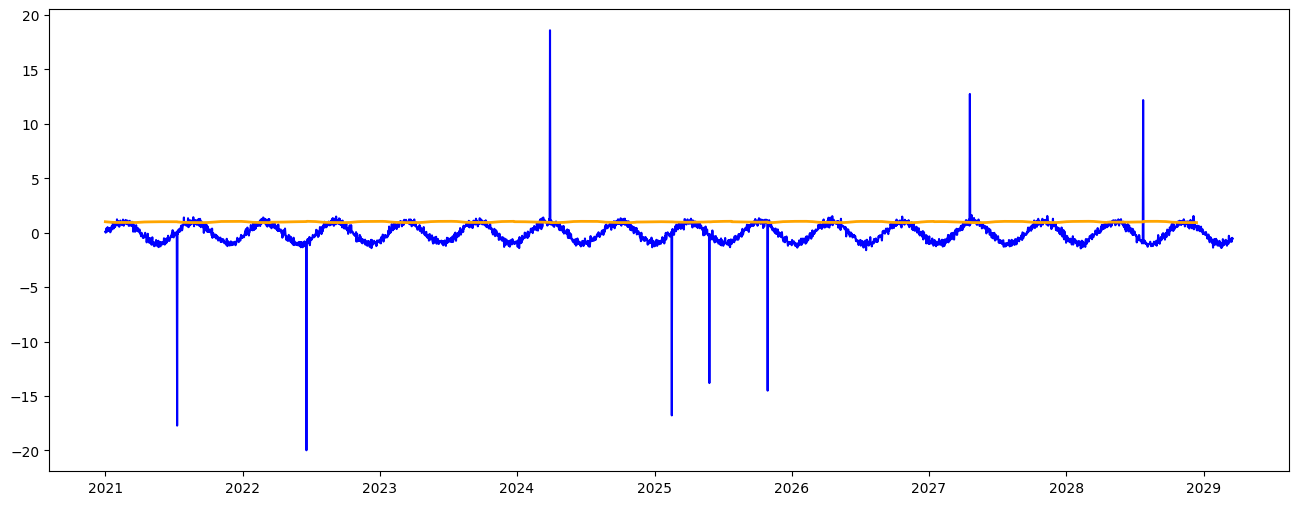

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Plot the original time series
plt.plot(series["ds"], series["y"], label="Original Series", color="blue")

# Plot the model's reconstruction error (anomaly score)
plt.plot(preds_df.index, preds_df["Error"], label="Reconstruction Error", color="orange", linewidth=2)

**What Does Each Anomaly Score Represent?**


The anomaly score at time t is based on how well the model can reconstruct the window that ends at time t.

A high score at time t suggests that the recent pattern (last N_LAGS points ending at t) was "unusual" for the model.

**How Should You Interpret the Plot?**
The blue curve: Your original time series.

The orange curve: The anomaly score (reconstruction error), aligned with the last point of each window.
The first N_LAGS points are NaN because the model doesn't have enough history to compute a score.

High anomaly score at t: Means the model could not accurately reconstruct the recent N_LAGS-length segment ending at t (possible anomaly).